In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import tarfile
import glob
import csv
import gc
import time
import random
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, UnidentifiedImageError
import cv2
from collections import Counter, defaultdict

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torchinfo import summary as Summary

import torchvision.models as models
from torchvision import transforms, datasets
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from torchvision.transforms import Compose, ToTensor, Normalize

from torchvision.transforms import ToPILImage
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import torchvision.utils as vutils

print('All modules imported succesfully !')


torch.cuda.empty_cache()

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print(f"Device : { 'cuda' if torch.cuda.is_available() else 'cpu'}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

All modules imported succesfully !
CUDA Available: True
CUDA Device Count: 1
Device : cuda


In [2]:
# Printing directory structure to provide an overview of the dataset.
def print_directory_structure(root_dir, indent_level=0):
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for i,file in enumerate(files):
            if i < 5:
                print(f'{subindent}{file}')
            if i==5:
                print(f'{subindent}...')
                break

input_dir = '/kaggle/input/'
print_directory_structure(input_dir)

/
face-mask-12k-images-dataset/
    Face Mask Dataset/
        Validation/
            WithoutMask/
                1017.png
                4803.png
                5106.png
                3765.png
                780.png
                ...
            WithMask/
                Augmented_167_9046481.png
                Augmented_806_8045721.png
                Augmented_178_9249152.png
                Augmented_579_5570178.png
                Augmented_534_7277080.png
                ...
        Test/
            WithoutMask/
                4353.png
                5703.png
                3824.png
                4352.png
                4805.png
                ...
            WithMask/
                Augmented_735_9235977.png
                Augmented_666_6106924.png
                Augmented_340_1318554.png
                Augmented_289_205760.png
                Augmented_194_786765.png
                ...
        Train/
            WithoutMask/
                5511.png
     

In [3]:
BATCH_SIZE = 32
IM_SHAPE = (64,64,3)

In [4]:
# Define image transformations (normalize to [-1,1] similar to TensorFlow)
transform = transforms.Compose([
    transforms.Resize((IM_SHAPE[0], IM_SHAPE[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale to [-1,1]
])

class FaceMaskDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".png")])
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB (handle grayscale images)

        if self.transform:
            image = self.transform(image)

        return image  # No labels since the original dataset uses label_mode=None in TensorFlow

# Define dataset paths
train_masked_path = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/"
train_unmasked_path = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/"
test_masked_path = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/"

# Load datasets using custom dataset class
train_masked_dataset = FaceMaskDataset(train_masked_path, transform=transform)
train_unmasked_dataset = FaceMaskDataset(train_unmasked_path, transform=transform)
test_masked_dataset = FaceMaskDataset(test_masked_path, transform=transform)

# Create DataLoaders
BATCH_SIZE = 32
test_masked_loader = DataLoader(test_masked_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Create a zipped dataset that pairs masked & unmasked images
class ZippedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        assert len(dataset1) == len(dataset2), "Datasets must have the same length"
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        return len(self.dataset1)

    def __getitem__(self, idx):
        img1 = self.dataset1[idx]
        img2 = self.dataset2[idx]
        return img1, img2  # Return paired images

train_dataset = ZippedDataset(train_masked_dataset, train_unmasked_dataset)

# Create a DataLoader for the combined dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Check sample batch shapes
for batch in train_loader:
    masked_batch, unmasked_batch = batch
    print(f"Masked Batch Shape: {masked_batch.shape}")
    print(f"Unmasked Batch Shape: {unmasked_batch.shape}")
    break  # Only print for the first batch

Masked Batch Shape: torch.Size([32, 3, 64, 64])
Unmasked Batch Shape: torch.Size([32, 3, 64, 64])


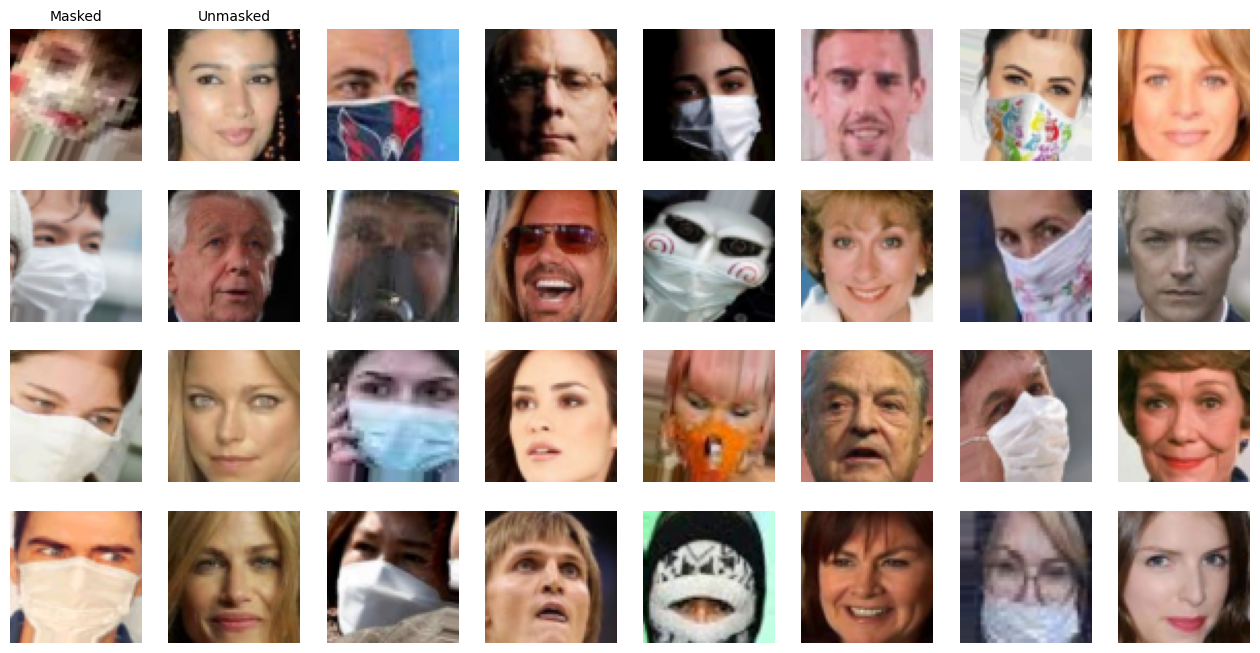

In [5]:
# Function to visualize n masked-unmasked pairs side by side
def visualize_pairs(dataloader, n=16):
    assert int(n**0.5)**2 == n, "n must be a perfect square"

    rows = int(n**0.5)  # Square grid rows
    cols = rows * 2      # Each pair occupies 2 columns

    plt.figure(figsize=(cols * 2, rows * 2))

    k = 0  # Track subplot index
    for masked_batch, unmasked_batch in dataloader:
        for i in range(n):
            # Display masked image
            ax = plt.subplot(rows, cols, k + 1)
            img_masked = masked_batch[i].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
            img_masked = (img_masked + 1) / 2  # Denormalize
            plt.imshow(img_masked)
            plt.axis("off")
            if i == 0:
                ax.set_title("Masked", fontsize=10)

            # Display corresponding unmasked image
            ax = plt.subplot(rows, cols, k + 2)
            img_unmasked = unmasked_batch[i].permute(1, 2, 0).cpu().numpy()
            img_unmasked = (img_unmasked + 1) / 2
            plt.imshow(img_unmasked)
            plt.axis("off")
            if i == 0:
                ax.set_title("Unmasked", fontsize=10)

            k += 2  # Move to next pair
            
            if k >= n * 2:  # Stop after n pairs
                break

        break  # Take only the first batch

    plt.show()

# Call function to visualize 16 pairs (4x4 grid with 2 columns per pair)
visualize_pairs(train_loader, n=16)

In [6]:
class StyleGANModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, style_dim=512):
        super(StyleGANModel, self).__init__()
        self.G_masked_unmasked = StyledGenerator(input_dim, hidden_dim, style_dim)
        self.G_unmasked_masked = StyledGenerator(input_dim, hidden_dim, style_dim)
        self.D_masked = StyleGANDiscriminator(input_dim, hidden_dim)
        self.D_unmasked = StyleGANDiscriminator(input_dim, hidden_dim)
        
    def forward(self, masked_images, unmasked_images):
        # Forward pass through generators
        fake_unmasked = self.G_masked_unmasked(masked_images)
        fake_masked = self.G_unmasked_masked(unmasked_images)
        
        # Cycle reconstructions
        cycle_masked = self.G_unmasked_masked(fake_unmasked)
        cycle_unmasked = self.G_masked_unmasked(fake_masked)
        
        return {
            'fake_unmasked': fake_unmasked,
            'fake_masked': fake_masked,
            'cycle_masked': cycle_masked,
            'cycle_unmasked': cycle_unmasked
        }

class StyledGenerator(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, style_dim=512):
        super(StyledGenerator, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, 3, 2, 1),
            nn.InstanceNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hidden_dim, hidden_dim*2, 3, 2, 1),
            nn.InstanceNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, 2, 1),
            nn.InstanceNorm2d(hidden_dim*4),
            nn.ReLU(inplace=True)
        )
        
        # Style Modulation
        self.style_dim = style_dim
        encoded_size = hidden_dim * 4 * 8 * 8  # Size after encoder
        
        self.style_modulation = nn.Sequential(
            nn.Linear(encoded_size, style_dim),
            nn.ReLU(inplace=True),
            nn.Linear(style_dim, hidden_dim * 4 * 8 * 8),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, 4, 2, 1),
            nn.InstanceNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, 4, 2, 1),
            nn.InstanceNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(hidden_dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Encode
        encoded = self.encoder(x)
        
        # Style modulation
        encoded_flat = encoded.view(batch_size, -1)
        styled = self.style_modulation(encoded_flat)
        styled = styled.view(batch_size, -1, 8, 8)
        
        # Decode
        output = self.decoder(styled)
        return output

class StyleGANDiscriminator(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(StyleGANDiscriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input layer
            nn.Conv2d(input_dim, hidden_dim, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Hidden layers
            nn.Conv2d(hidden_dim, hidden_dim*2, 4, 2, 1),
            nn.InstanceNorm2d(hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(hidden_dim*2, hidden_dim*4, 4, 2, 1),
            nn.InstanceNorm2d(hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer
            nn.Conv2d(hidden_dim*4, 1, 4, 1, 1),
        )
        
    def forward(self, x):
        return self.model(x)

In [7]:
# Initialize model
model = StyleGANModel(input_dim=3, hidden_dim=64).to(device)

# Initialize optimizers
G_optimizer = optim.Adam([
    *model.G_masked_unmasked.parameters(),
    *model.G_unmasked_masked.parameters()
], lr=2e-4, betas=(0.5, 0.999))

D_optimizer = optim.Adam([
    *model.D_masked.parameters(),
    *model.D_unmasked.parameters()
], lr=2e-4, betas=(0.5, 0.999))

# Print model summary
Summary(model, [(1, 3, 64, 64), (1, 3, 64, 64)])

Layer (type:depth-idx)                   Output Shape              Param #
StyleGANModel                            [1, 3, 64, 64]            1,325,954
├─StyledGenerator: 1-1                   [1, 3, 64, 64]            --
│    └─Sequential: 2-1                   [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           1,792
│    │    └─InstanceNorm2d: 3-2          [1, 64, 32, 32]           --
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 128, 16, 16]          73,856
│    │    └─InstanceNorm2d: 3-5          [1, 128, 16, 16]          --
│    │    └─ReLU: 3-6                    [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-7                  [1, 256, 8, 8]            295,168
│    │    └─InstanceNorm2d: 3-8          [1, 256, 8, 8]            --
│    │    └─ReLU: 3-9                    [1, 256, 8, 8]            --
│    └─Sequential: 2-2                   [1, 16384]               

In [10]:
import os
import gc
import csv
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.transforms import ToPILImage
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure


def compute_psnr(original, generated):
    """Compute PSNR between original and generated images"""
    psnr_metric = PeakSignalNoiseRatio().to(original.device)
    return psnr_metric(original, generated).item()


def compute_ssim(original, generated):
    """Compute SSIM between original and generated images"""
    ssim_metric = StructuralSimilarityIndexMeasure().to(original.device)
    return ssim_metric(original, generated).item()


def visualize_results(model, masked_images, unmasked_images, epoch, output_dir="results"):
    """Generate and save side-by-side visualization of inputs vs outputs"""
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    
    with torch.no_grad():
        outputs = model(masked_images, unmasked_images)
        fake_unmasked = outputs['fake_unmasked']

    # Create a grid of images: Masked → Fake Unmasked → Real Unmasked
    images = torch.cat([
        masked_images,        # Input masked images
        fake_unmasked,        # Generated unmasked images
        unmasked_images       # Ground-truth unmasked images
    ])

    grid = vutils.make_grid(images, nrow=len(masked_images), normalize=True)

    # Save grid
    plt.figure(figsize=(15, 5))
    plt.imshow(ToPILImage()(grid.cpu()))
    plt.axis('off')
    plt.title(f'Epoch {epoch}')
    plt.show()
    plt.savefig(f"{output_dir}/epoch_{epoch}.png", bbox_inches='tight')
    plt.close()


# Hinge loss for discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = torch.mean(F.relu(1.0 - real_output))
    fake_loss = torch.mean(F.relu(1.0 + fake_output))
    return 0.5 * (real_loss + fake_loss)

# Hinge loss for generator
def generator_loss(fake_output):
    return -torch.mean(fake_output)

# Cycle consistency loss
def cycle_loss(real_image, cycled_image):
    return F.l1_loss(cycled_image, real_image)


def train_step(model, masked_images, unmasked_images, optimizers, lambda_cycle=10.0):
    """Perform a single training step for both generator and discriminator"""
    G_optimizer, D_optimizer = optimizers
    device = masked_images.device
    
    real_masked = masked_images.to(device)
    real_unmasked = unmasked_images.to(device)
    
    # Forward pass
    outputs = model(real_masked, real_unmasked)
    fake_unmasked = outputs['fake_unmasked']
    fake_masked = outputs['fake_masked']
    cycle_masked = outputs['cycle_masked']
    cycle_unmasked = outputs['cycle_unmasked']
    
    # Train Discriminators
    D_optimizer.zero_grad()
    
    # Discriminator loss for masked images
    d_real_masked = model.D_masked(real_masked)
    d_fake_masked = model.D_masked(fake_masked.detach())
    d_masked_loss = discriminator_loss(d_real_masked, d_fake_masked)
    
    # Discriminator loss for unmasked images
    d_real_unmasked = model.D_unmasked(real_unmasked)
    d_fake_unmasked = model.D_unmasked(fake_unmasked.detach())
    d_unmasked_loss = discriminator_loss(d_real_unmasked, d_fake_unmasked)
    
    # Total discriminator loss
    d_loss = d_masked_loss + d_unmasked_loss
    d_loss.backward()
    D_optimizer.step()
    
    # Train Generators
    G_optimizer.zero_grad()
    
    # Adversarial loss
    g_masked_loss = generator_loss(model.D_masked(fake_masked))
    g_unmasked_loss = generator_loss(model.D_unmasked(fake_unmasked))
    
    # Cycle consistency loss
    cycle_masked_loss = cycle_loss(real_masked, cycle_masked)
    cycle_unmasked_loss = cycle_loss(real_unmasked, cycle_unmasked)
    
    # Total generator loss
    g_loss = (g_masked_loss + g_unmasked_loss + 
              lambda_cycle * (cycle_masked_loss + cycle_unmasked_loss))
    
    g_loss.backward()
    G_optimizer.step()
    
    return {
        'g_loss': g_loss.item(),
        'd_loss': d_loss.item(),
        'cycle_loss': (cycle_masked_loss + cycle_unmasked_loss).item()
    }


def train_model(
    model,
    train_loader,
    optimizers,
    epochs=100,
    lambda_cycle=10.0,
    dir_checkpoint="checkpoints",
    csv_name="training_log.csv",
    checkpoint_name="best_model.pth",
    patience=15,
    visualize_every=10
):
    """Train the model, logging PSNR and SSIM, and visualize outputs every 10 epochs"""
    device = next(model.parameters()).device
    G_optimizer, D_optimizer = optimizers
    
    # Initialize tracking variables
    best_psnr = 0.0
    best_ssim = 0.0
    no_improvement_count = 0
    metrics_history = {
        'g_loss': [], 'd_loss': [], 
        'cycle_loss': [], 'psnr': [], 
        'ssim': []
    }

    # Setup logging
    os.makedirs(dir_checkpoint, exist_ok=True)
    csv_path = os.path.join(dir_checkpoint, csv_name)
    
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'G_Loss', 'D_Loss', 'Cycle_Loss', 'PSNR', 'SSIM'])

    # Get sample batch for visualization
    sample_batch_masked, sample_batch_unmasked = next(iter(train_loader))
    sample_batch_masked = sample_batch_masked[:4].to(device)
    sample_batch_unmasked = sample_batch_unmasked[:4].to(device)

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        model.train()
        
        # Initialize epoch metrics
        epoch_metrics = {key: 0.0 for key in metrics_history}
        
        train_bar = tqdm(train_loader, desc="Training", leave=False)
        
        for masked_images, unmasked_images in train_bar:
            masked_images = masked_images.to(device)
            unmasked_images = unmasked_images.to(device)

            # Training step
            batch_losses = train_step(
                model, masked_images, unmasked_images, optimizers, lambda_cycle
            )
            
            # Forward pass for metrics
            with torch.no_grad():
                outputs = model(masked_images, unmasked_images)
                fake_unmasked = outputs['fake_unmasked']
                batch_psnr = compute_psnr(unmasked_images, fake_unmasked)
                batch_ssim = compute_ssim(unmasked_images, fake_unmasked)

            # Update metrics
            for key in batch_losses:
                epoch_metrics[key] += batch_losses[key]
            epoch_metrics['psnr'] += batch_psnr
            epoch_metrics['ssim'] += batch_ssim

            # Update tqdm progress bar
            train_bar.set_postfix({
                'G_Loss': f"{batch_losses['g_loss']:.4f}",
                'D_Loss': f"{batch_losses['d_loss']:.4f}",
                'PSNR': f"{batch_psnr:.2f}",
                'SSIM': f"{batch_ssim:.4f}"
            })

        # Normalize epoch metrics
        num_batches = len(train_loader)
        avg_metrics = {key: value / num_batches for key, value in epoch_metrics.items()}

        print(f'G_loss : {avg_metrics["g_loss"]:.4f} | D_Loss : {avg_metrics["d_loss"]:.4f} | Cycle Loss : {avg_metrics["cycle_loss"]:.4f} | PSNR : {avg_metrics["psnr"]:.2f} | SSIM : {avg_metrics["ssim"]:.4f}')

        # Save best model
        if avg_metrics['psnr'] > best_psnr or avg_metrics['ssim'] > best_ssim:
            best_psnr = max(best_psnr, avg_metrics['psnr'])
            best_ssim = max(best_ssim, avg_metrics['ssim'])
            no_improvement_count = 0
            torch.save(model.state_dict(), os.path.join(dir_checkpoint, checkpoint_name))
            print("✅ Model saved as PSNR/SSIM improved.")
        else:
            no_improvement_count += 1

        # Early stopping
        if no_improvement_count >= patience:
            print(f"🚨 Early stopping triggered after {epoch + 1} epochs.")
            break

        # Visualization every 10 epochs
        if (epoch + 1) % visualize_every == 0:
            visualize_results(model, sample_batch_masked, sample_batch_unmasked, epoch)

        gc.collect()
        if device == 'cuda':
            torch.cuda.empty_cache()


Epoch [1/50]


G_loss : 10.6392 | D_Loss : 1.0373 | Cycle Loss : 0.8635 | PSNR : 11.12 | SSIM : 0.0639
✅ Model saved as PSNR/SSIM improved.

Epoch [2/50]


G_loss : 11.0578 | D_Loss : 0.5009 | Cycle Loss : 0.8005 | PSNR : 11.24 | SSIM : 0.0782
✅ Model saved as PSNR/SSIM improved.


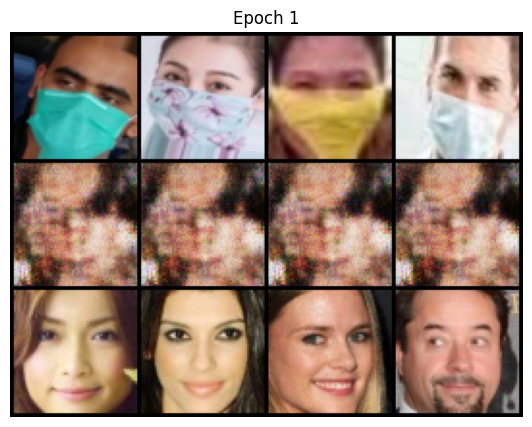


Epoch [3/50]


G_loss : 11.3391 | D_Loss : 0.4739 | Cycle Loss : 0.7931 | PSNR : 11.35 | SSIM : 0.0861
✅ Model saved as PSNR/SSIM improved.

Epoch [4/50]


G_loss : 11.7036 | D_Loss : 0.5666 | Cycle Loss : 0.7897 | PSNR : 11.20 | SSIM : 0.0897
✅ Model saved as PSNR/SSIM improved.


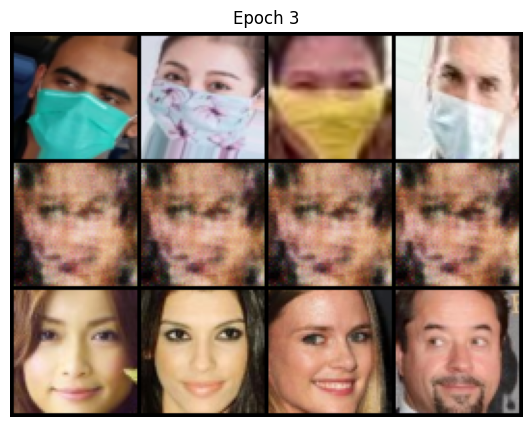


Epoch [5/50]


G_loss : 11.2741 | D_Loss : 0.7115 | Cycle Loss : 0.7649 | PSNR : 10.91 | SSIM : 0.0766

Epoch [6/50]


G_loss : 11.0509 | D_Loss : 0.7346 | Cycle Loss : 0.7492 | PSNR : 10.77 | SSIM : 0.0740


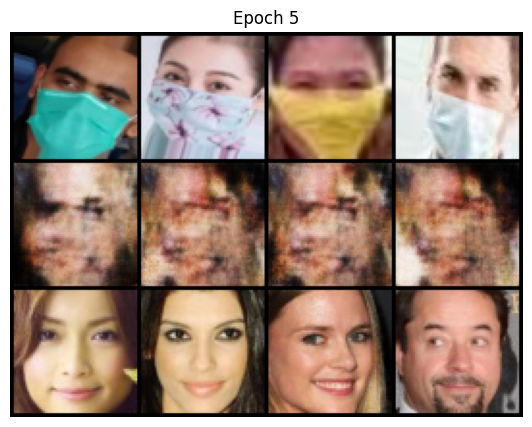


Epoch [7/50]


G_loss : 10.7300 | D_Loss : 0.6585 | Cycle Loss : 0.7345 | PSNR : 10.74 | SSIM : 0.0723

Epoch [8/50]


G_loss : 10.6182 | D_Loss : 0.7283 | Cycle Loss : 0.7173 | PSNR : 10.78 | SSIM : 0.0816


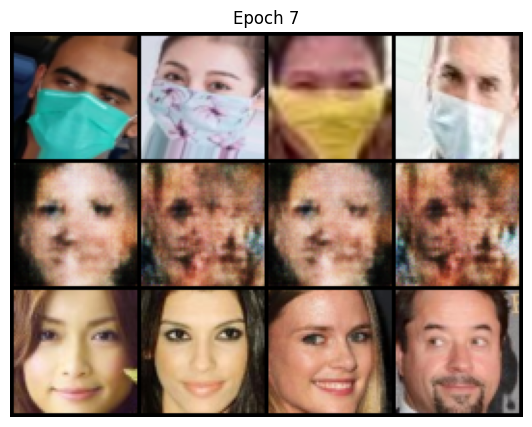


Epoch [9/50]


G_loss : 10.1685 | D_Loss : 0.7166 | Cycle Loss : 0.6975 | PSNR : 10.72 | SSIM : 0.0754

Epoch [10/50]


G_loss : 9.9157 | D_Loss : 0.7677 | Cycle Loss : 0.6722 | PSNR : 10.92 | SSIM : 0.0890


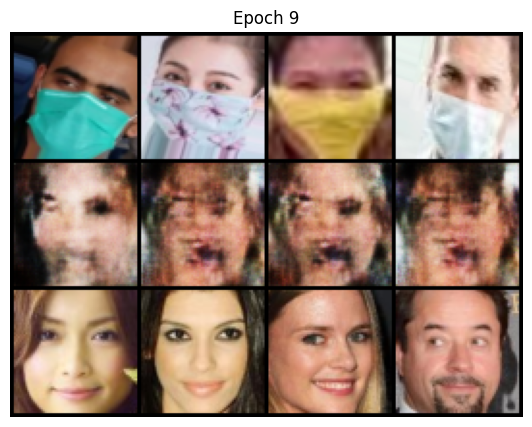


Epoch [11/50]


G_loss : 9.6111 | D_Loss : 0.7724 | Cycle Loss : 0.6465 | PSNR : 10.72 | SSIM : 0.0834

Epoch [12/50]


G_loss : 9.2424 | D_Loss : 0.8064 | Cycle Loss : 0.6287 | PSNR : 10.81 | SSIM : 0.0840


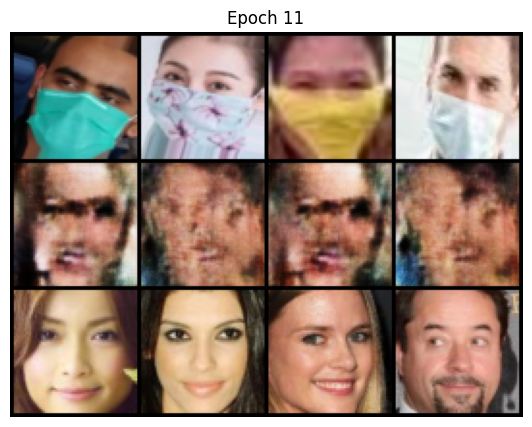


Epoch [13/50]


G_loss : 9.2303 | D_Loss : 0.7311 | Cycle Loss : 0.6172 | PSNR : 10.90 | SSIM : 0.0857

Epoch [14/50]


G_loss : 9.2092 | D_Loss : 0.7411 | Cycle Loss : 0.6082 | PSNR : 10.82 | SSIM : 0.0874


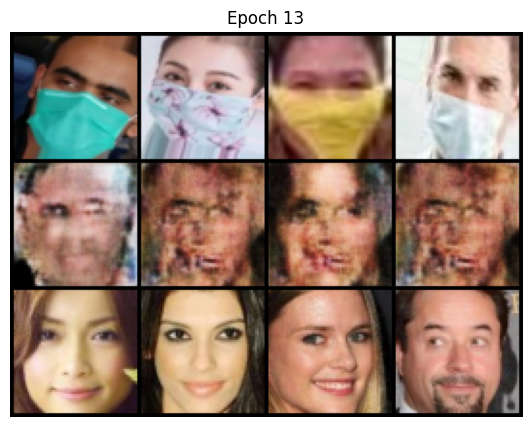


Epoch [15/50]


G_loss : 9.1435 | D_Loss : 0.6998 | Cycle Loss : 0.5971 | PSNR : 10.77 | SSIM : 0.0810

Epoch [16/50]


G_loss : 9.1449 | D_Loss : 0.6955 | Cycle Loss : 0.5854 | PSNR : 10.90 | SSIM : 0.0892


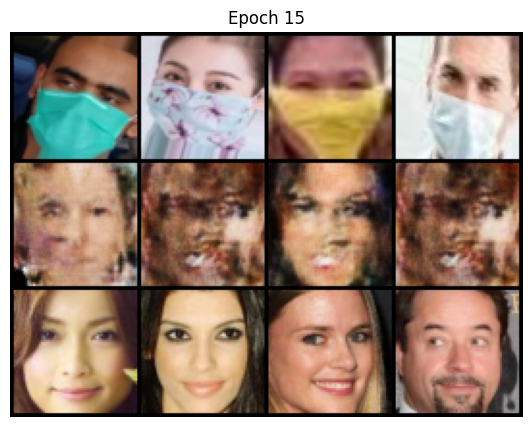


Epoch [17/50]


G_loss : 9.0600 | D_Loss : 0.6768 | Cycle Loss : 0.5765 | PSNR : 10.82 | SSIM : 0.0901
✅ Model saved as PSNR/SSIM improved.

Epoch [18/50]


G_loss : 8.8573 | D_Loss : 0.6841 | Cycle Loss : 0.5686 | PSNR : 10.90 | SSIM : 0.0906
✅ Model saved as PSNR/SSIM improved.


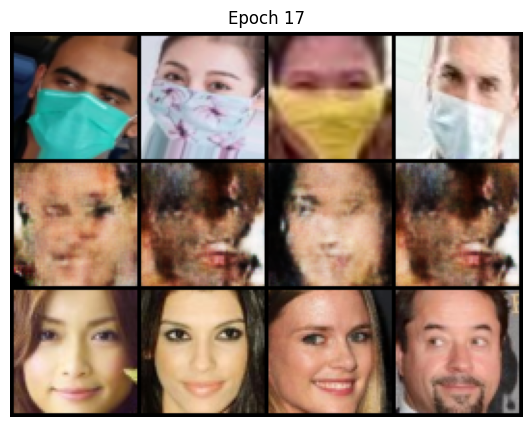


Epoch [19/50]


G_loss : 8.6952 | D_Loss : 0.6976 | Cycle Loss : 0.5579 | PSNR : 10.71 | SSIM : 0.0849

Epoch [20/50]


G_loss : 8.6859 | D_Loss : 0.6628 | Cycle Loss : 0.5530 | PSNR : 10.76 | SSIM : 0.0883


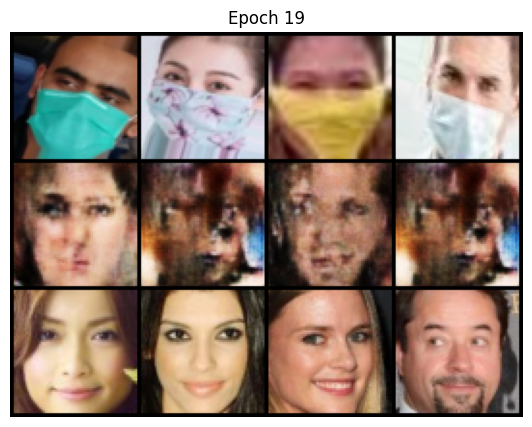


Epoch [21/50]


G_loss : 8.8330 | D_Loss : 0.6518 | Cycle Loss : 0.5480 | PSNR : 10.80 | SSIM : 0.0867

Epoch [22/50]


G_loss : 8.8146 | D_Loss : 0.6439 | Cycle Loss : 0.5466 | PSNR : 10.72 | SSIM : 0.0834


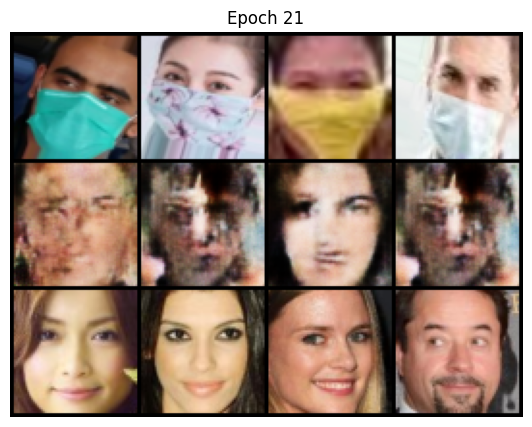


Epoch [23/50]


G_loss : 8.8767 | D_Loss : 0.6155 | Cycle Loss : 0.5425 | PSNR : 10.80 | SSIM : 0.0861

Epoch [24/50]


G_loss : 9.0817 | D_Loss : 0.5803 | Cycle Loss : 0.5445 | PSNR : 10.77 | SSIM : 0.0833


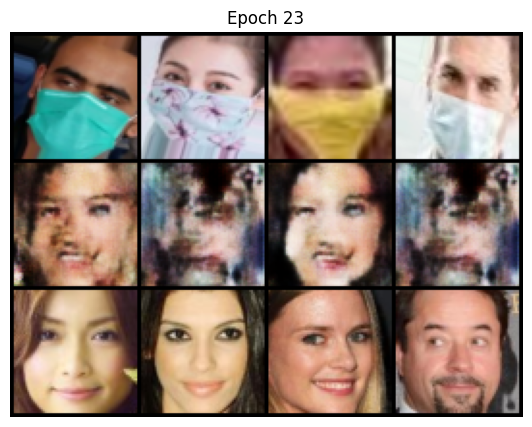


Epoch [25/50]


G_loss : 9.0336 | D_Loss : 0.5559 | Cycle Loss : 0.5413 | PSNR : 10.87 | SSIM : 0.0817

Epoch [26/50]


G_loss : 9.0475 | D_Loss : 0.5255 | Cycle Loss : 0.5364 | PSNR : 10.84 | SSIM : 0.0789


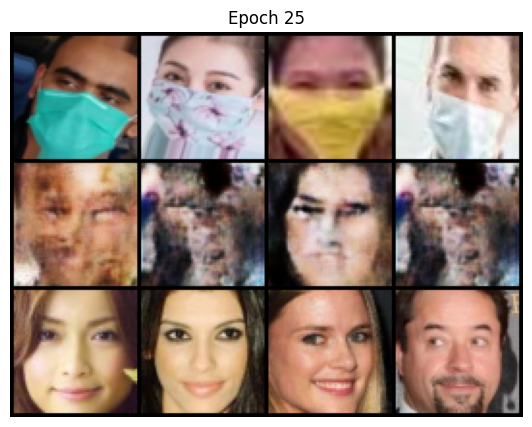


Epoch [27/50]


G_loss : 9.0484 | D_Loss : 0.5035 | Cycle Loss : 0.5397 | PSNR : 10.77 | SSIM : 0.0774

Epoch [28/50]


G_loss : 9.1188 | D_Loss : 0.5176 | Cycle Loss : 0.5385 | PSNR : 10.78 | SSIM : 0.0785


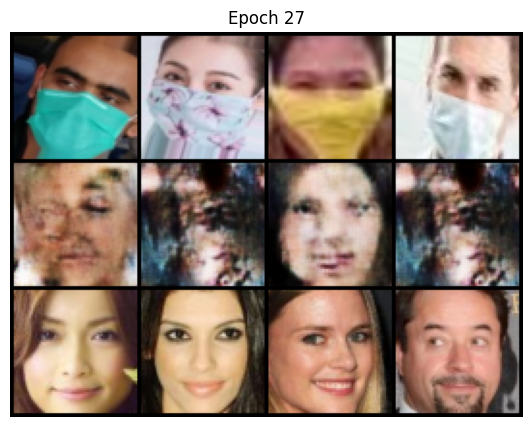


Epoch [29/50]


G_loss : 9.0720 | D_Loss : 0.5059 | Cycle Loss : 0.5360 | PSNR : 10.74 | SSIM : 0.0773

Epoch [30/50]


G_loss : 9.1094 | D_Loss : 0.5198 | Cycle Loss : 0.5386 | PSNR : 10.77 | SSIM : 0.0787


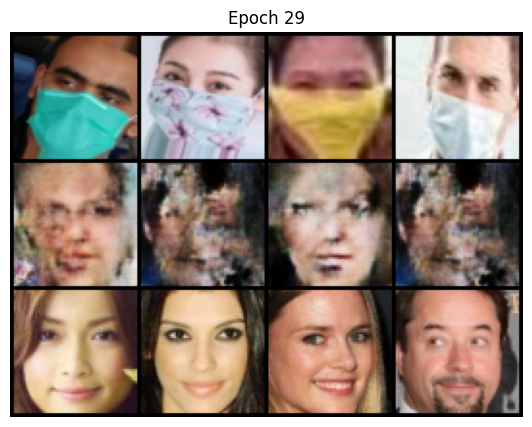


Epoch [31/50]


G_loss : 9.1119 | D_Loss : 0.5100 | Cycle Loss : 0.5336 | PSNR : 10.88 | SSIM : 0.0804

Epoch [32/50]


G_loss : 9.1162 | D_Loss : 0.5057 | Cycle Loss : 0.5299 | PSNR : 10.89 | SSIM : 0.0797


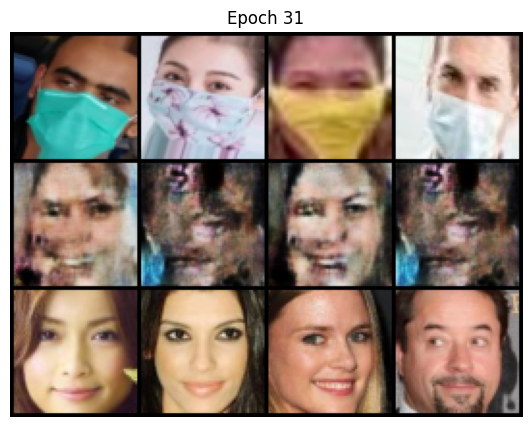


Epoch [33/50]


G_loss : 9.0796 | D_Loss : 0.4771 | Cycle Loss : 0.5307 | PSNR : 10.85 | SSIM : 0.0759
🚨 Early stopping triggered after 33 epochs.


In [12]:
# Initialize model
model = StyleGANModel(input_dim=3, hidden_dim=64).to(device)

# Initialize optimizers
G_optimizer = optim.Adam([
    *model.G_masked_unmasked.parameters(),
    *model.G_unmasked_masked.parameters()
], lr=2e-4, betas=(0.5, 0.999))

D_optimizer = optim.Adam([
    *model.D_masked.parameters(),
    *model.D_unmasked.parameters()
], lr=2e-4, betas=(0.5, 0.999))


metrics_history = train_model(
    model=model,
    train_loader=train_loader,
    optimizers=(G_optimizer, D_optimizer),
    epochs=50,
    lambda_cycle=10.0,
    patience=15,
    visualize_every=2,
    dir_checkpoint="checkpoints",
    csv_name="training_log.csv",
    checkpoint_name="best_model.pth",
)

In [13]:
import zipfile
import os

zip_path = "/kaggle/working/style-cycle-gan-outputs.zip"
folder_to_zip = "/kaggle/working"

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            if file == "style-cycle-gan-outputs.zip":
                continue  # Avoid including the zip file in itself
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, folder_to_zip)
            zipf.write(file_path, arcname)

print("Zipping completed: style-cycle-gan-outputs.zip saved in /kaggle/working")

Zipping completed: style-cycle-gan-outputs.zip saved in /kaggle/working
